In [1]:
import sympy as sp
import numpy as np
from urdf_parser_py.urdf import URDF
import os
import matplotlib.pyplot as plt

CatBot Lab Context: This notebook supports the CatBot course and focuses on Jacobian.

Check 
https://ethz.ch/content/dam/ethz/special-interest/mavt/robotics-n-intelligent-systems/rsl-dam/documents/RobotDynamics2017/RD_HS2017script.pdf

pag 54

In [2]:
URDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/catbot_description/urdf/'
urdf_model     = URDF_DIR + 'catbot.urdf'\

urdf_str = open(urdf_model, 'r').read()
robot_urdf = URDF.from_xml_string(urdf_str)


In [3]:
theta0 = sp.Symbol('theta_0')
theta1 = sp.Symbol('theta_1')
theta2 = sp.Symbol('theta_2')


In [4]:
def getTransform(pos, euler_ang):
    [x,y,z]          = pos
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = sp.Matrix([[1,            0,              0,             0],
                   [0,            sp.cos(roll),   -sp.sin(roll), 0],
                   [0,            sp.sin(roll),   sp.cos(roll),  0],
                   [0,            0,              0,             1]])
    
    Ry = sp.Matrix([[sp.cos(yaw),  0,              sp.sin(yaw),   0],
                   [0,            1,              0,             0],
                   [-sp.sin(yaw), 0,              sp.cos(yaw),   0],
                   [0,            0,              0,             1]])
    
    
    Rz = sp.Matrix([[sp.cos(pit), -sp.sin(pit),   0,             0],
                   [sp.sin(pit),  sp.cos(pit),   0,             0],
                   [0,            0,             1,             0],
                   [0,            0,             0,             1]])
    
    T_pos = sp.Matrix([[1, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])
    
    Rxyz = Rz*Ry*Rx
    
    return T_pos * Rxyz


def getJointTransforms(robot_urdf, leg, angles):
    tf_joints = {}

    for joint in robot_urdf.joints:
        if leg in joint.name:
            pos       = np.array(joint.origin.xyz)
            euler_ang = [0,0,0]
            
            
            if 'hip1' in joint.name:
                euler_ang[0] = angles[0]
                tf_joints['hip1'] = getTransform(pos, euler_ang)
            
            if 'hip2' in joint.name:
                euler_ang[2] = angles[1]
                tf_joints['hip2'] = getTransform(pos, euler_ang)
                
            if 'knee' in joint.name:
                euler_ang[2] = angles[2]                
                tf_joints['knee'] = getTransform(pos, euler_ang)
            if 'feet' in joint.name:
                tf_joints['feet'] = getTransform(pos, euler_ang)
        
    return tf_joints

tf_joints = getJointTransforms(robot_urdf, 'fl', [theta0, theta1, theta2])

rot_hip1 = getTransform([0,0,0], [0,0,theta1])
rot_knee = getTransform([0,0,0], [0,0,theta2])
L2 = rot_hip1*rot_knee*tf_joints['feet']
L2 =  sp.simplify(L2[:3,3])
display(L2)

L1 = rot_hip1*tf_joints['knee']*tf_joints['feet']
L1 =  sp.simplify(L1[:3,3])
display(L1)

Matrix([
[-0.10938*sin(theta_1 + theta_2)],
[                       -0.01451],
[-0.10938*cos(theta_1 + theta_2)]])

Matrix([
[-0.11335*sin(theta_1) - 0.10938*sin(theta_1 + theta_2)],
[                                              -0.01887],
[-0.11335*cos(theta_1) - 0.10938*cos(theta_1 + theta_2)]])

# Torque in theta1

We define the vector $L_1$ as the distance from the hip_1 to the feet in the hip_ref reference system, in the $xz$ plane

\begin{equation}
\mathbf{L}_1 = \Big[ |l_1|sin(\theta_1) + |l_2|sin(\theta_1 + \theta_2), \quad 0, \quad -|l_1|cos(\theta_1) - |l_2|cos(\theta_1 + \theta_2) \Big]
\end{equation}

where $l_1$ and $l_2$ are the length of the femur and tibia links of the leg in the $xz$ plane

then the torque is defined as $\mathbf{\tau_1} =
 \mathbf{L}_1  \times \mathbf{F} $. Since we only measure the torque in the xy plane, the torque is defined in the $y$ axis as:
 
 \begin{equation}
 \tau_1 = - L_{1,x}F_z +  L_{1,z}F_x = - F_z \Big( |l_1|sin(\theta_1) + |l_2|sin(\theta_1 + \theta_2) \Big) - F_x \Big(|l_1|cos(\theta_1) + |l_2|cos(\theta_1 + \theta_2) \Big)
 \end{equation}

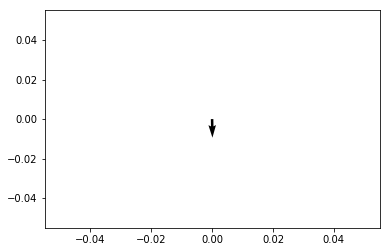

In [21]:
L1_norm = 0.11335
L2_norm = 0.10938

th1 = np.pi/4
th2 = -np.pi/2
L1 = np.array([ L1_norm*np.sin(th1) + L2_norm*np.sin(th1 + th2), 0, -L1_norm*np.cos(th1) -L2_norm*np.cos(th1 + th2) ])

plt.quiver(0,0,L1[0], L1[2])

([<matplotlib.axis.XTick at 0x7f2250640950>,
 <a list of 2 Text xticklabel objects>)

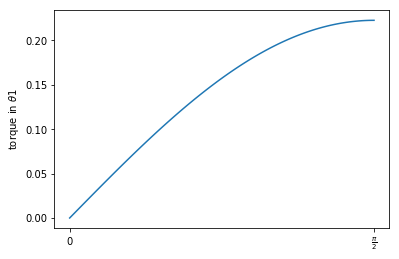

In [18]:

th1_arr = np.linspace(0, np.pi/2, 100)
th2 = 0
F = np.array([0,0,1])


force = []
for th1 in th1_arr:
    L1 = np.array([ L1_norm*np.sin(th1) + L2_norm*np.sin(th1 + th2), 0, -L1_norm*np.cos(th1) -L2_norm*np.cos(th1 + th2) ])
    force.append( F[2]*L1[0] - F[0]*L1[2])#np.cross(F, L1)[1] )
    
plt.plot(th1_arr, force)
plt.ylabel(r'torque in $\theta1$')
plt.xticks([th1_arr[0], th1_arr[-1]], [r'$0$', r'$\frac{\pi}{2}$'])


# Torque in theta2

We define the vector $L_2$ as the distance from the knee to the feet in the hip_ref reference system, in the $xz$ plane

\begin{equation}
\mathbf{L}_2 = \Big[ |l_2|sin(\theta_1 + \theta_2), \quad 0, - |l_2|cos(\theta_1 + \theta_2) \Big]
\end{equation}


then the torque is defined as $\mathbf{\tau_2} =
 \mathbf{L}_2  \times \mathbf{F} $. Since we only measure the torque in the xy plane, the torque is defined in the $y$ axis as:
 
 \begin{equation}
 \tau_2 = - L_{2,x}F_z +  L_{2,z}F_x = - F_z \Big( |l_2|sin(\theta_1 + \theta_2) \Big) - F_x \Big( |l_2|cos(\theta_1 + \theta_2) \Big)
 \end{equation}

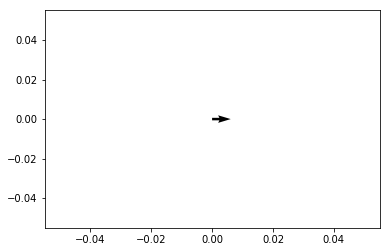

In [25]:
th1 = np.pi/2
th2 = 0
L2 = np.array([L2_norm*np.sin(th1 + th2), 0,  -L2_norm*np.cos(th1 + th2) ])

plt.quiver(0,0,L2[0], L2[2])

([<matplotlib.axis.XTick at 0x7f2250895f90>,
 <a list of 3 Text xticklabel objects>)

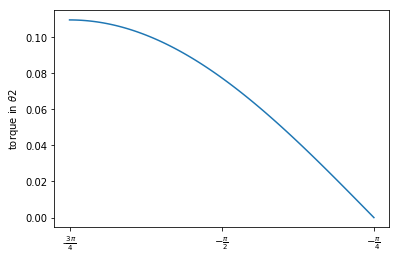

In [8]:
th1 =  np.pi/4
th2_arr = np.linspace(-np.pi/4, -np.pi/2 - np.pi/4, 100)

force = []
for th2 in th2_arr:
    L2 = np.array([ L2_norm*np.sin(th1 + th2), 0, -L2_norm*np.cos(th1 + th2) ])
    F = np.array([0,0,1])
    force.append(np.cross(L2, F)[1])
    
plt.plot(th2_arr, force)
plt.ylabel(r'torque in $\theta2$')
plt.xticks([th2_arr[0], -np.pi/2, th2_arr[-1]], [r'$-\frac{\pi}{4}$', r'$-\frac{\pi}{2}$', r'-$\frac{3\pi}{4}$'])


# Building the 'Jacobian'

We have the equivalence between force and torques:

\begin{equation}
 \begin{cases}
 \tau_1 = -  F_z \Big( |l_1|sin(\theta_1) + |l_2|sin(\theta_1 + \theta_2) \Big) - F_x \Big(|l_1|cos(\theta_1) + |l_2|cos(\theta_1 + \theta_2) \Big)  \\
  \tau_1 =  - F_z \Big( |l_2|sin(\theta_1 + \theta_2) \Big) - F_x \Big( |l_2|cos(\theta_1 + \theta_2) \Big)
 \end{cases}
 \end{equation}
 
 we can write this in matrices notation:
 
\begin{equation}
\begin{pmatrix}
\tau_1 \\
\tau_2
\end{pmatrix} = 
\begin{pmatrix}
-|l_1|cos(\theta_1) - |l_2|cos(\theta_1 + \theta_2) &  -|l_1|sin(\theta_1) - |l_2|sin(\theta_1 + \theta_2)\\
-|l_2|cos(\theta_1 + \theta_2)                      &   -|l_2|sin(\theta_1 + \theta_2)\\
\end{pmatrix} 
\begin{pmatrix}
F_x \\
F_z
\end{pmatrix} 
\end{equation}

where 

 
\begin{equation}
J = 
\begin{pmatrix}
-|l_1|cos(\theta_1) - |l_2|cos(\theta_1 + \theta_2) &  -|l_1|sin(\theta_1) - |l_2|sin(\theta_1 + \theta_2)\\
-|l_2|cos(\theta_1 + \theta_2)                      &   -|l_2|sin(\theta_1 + \theta_2)\\
\end{pmatrix} 
\end{equation}

is the Jacobian

In [5]:
def getJacobian(angles):
    _, th1, th2 = angles
    l1_norm = 0.11335
    l2_norm = 0.10938

    J = np.array([[ -l1_norm*np.cos(th1) - l2_norm*np.cos(th1 + th2), -l1_norm*np.sin(th1) - l2_norm*np.sin(th1 + th2) ],
                  [ -l2_norm*np.cos(th1 + th2),                       -l2_norm*np.sin(th1 + th2)                       ]])
    return J

def getPeudoInvJacobian(angles):
    J = getJacobian(angles)
    return np.linalg.pinv(J)

def getForces(angles, torques):
    J_inv = getPeudoInvJacobian(angles)
    _, torq1, torq2 = torques
    
    F = J_inv.dot([torq1, torq2])
    return np.array([F[0], 0, F[1]])

def getTorques(angles, force):
    J = getJacobian(angles)
    Fx, _, Fz = force
    
    torques = J.dot([Fx, Fz])
    return np.array([0, torques[0], torques[1]])
    

    

In [6]:
angles = [0,np.pi/4,-np.pi/2]
J = getJacobian(angles)

print(J)
print("")
print(getTorques(angles, [0,0,2]))


[[-0.15749389 -0.00280721]
 [-0.07734334  0.07734334]]

[ 0.         -0.00561443  0.15468668]


In [ ]:
J_inv = getPeudoInvJacobian(angles)


 

\begin{equation}
 \begin{cases}
 \tau_1 = -  F_z \Big( |l_1|sin(\theta_1) + |l_2|sin(\theta_1 + \theta_2) \Big) - F_x \Big(|l_1|cos(\theta_1) + |l_2|cos(\theta_1 + \theta_2) \Big)  \\
  \tau_1 =  - F_z \Big( |l_2|sin(\theta_1 + \theta_2) \Big) - F_x \Big( |l_2|cos(\theta_1 + \theta_2) \Big)
 \end{cases}
 \end{equation}
 
Our sensors only measure positive torques. Let's say that the force applied to the leg has an angle of $\alpha$ respect the $x$ axis so that $F = |F|(cos(\alpha), sin(\alpha)) $, then:

\begin{equation}
\begin{cases}
\text{for $\tau_1$ we need that } \quad  cos(\alpha)\Big( |l_1|cos(\theta_1) + |l_2|cos(\theta_1 + \theta_2)\Big) + sin(\alpha)\Big( |l_1|sin(\theta_1) + |l_2|sin(\theta_1 + \theta_2) \Big) > 0 \\
\text{for $\tau_2$ we need that } \quad  cos(\alpha)\Big( |l_2|cos(\theta_1 + \theta_2)\Big) + sin(\alpha)\Big(  |l_2|sin(\theta_1 + \theta_2) \Big) > 0
\end{cases}
\end{equation}

In [16]:
print(J_inv.dot([-1,1]))

[  9.1424392  -17.64446405]


In [7]:
def getTransform(pos, euler_ang):
    [x,y,z]          = pos
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = sp.Matrix([[1,            0,              0,             0],
                   [0,            sp.cos(roll),   -sp.sin(roll), 0],
                   [0,            sp.sin(roll),   sp.cos(roll),  0],
                   [0,            0,              0,             1]])
    
    Ry = sp.Matrix([[sp.cos(yaw),  0,              sp.sin(yaw),   0],
                   [0,            1,              0,             0],
                   [-sp.sin(yaw), 0,              sp.cos(yaw),   0],
                   [0,            0,              0,             1]])
    
    
    Rz = sp.Matrix([[sp.cos(pit), -sp.sin(pit),   0,             0],
                   [sp.sin(pit),  sp.cos(pit),   0,             0],
                   [0,            0,             1,             0],
                   [0,            0,             0,             1]])
    
    T_pos = sp.Matrix([[1, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])
    
    Rxyz = Rz*Ry*Rx
    
    return T_pos * Rxyz


def getJointTransforms(robot_urdf, leg, angles):
    tf_joints = {}

    for joint in robot_urdf.joints:
        if leg in joint.name:
            pos       = np.array(joint.origin.xyz)
            euler_ang = [0,0,0]
            
            if joint.name == '{:s}_ref'.format(leg):
                pos = np.array( joint.origin.xyz, dtype = 'float32' )
                tf_joints['ref'] = getTransform(pos, euler_ang)
                
            if 'hip1' in joint.name:
                euler_ang[0] = angles[0]
                tf_joints['hip1'] = getTransform(pos, euler_ang)
            
            if 'hip2' in joint.name:
                euler_ang[2] = angles[1]
                tf_joints['hip2'] = getTransform(pos, euler_ang)
                
            if 'knee' in joint.name:
                euler_ang[2] = angles[2]                
                tf_joints['knee'] = getTransform(pos, euler_ang)
            if 'feet' in joint.name:
                print(pos)
                tf_joints['feet'] = getTransform(pos, euler_ang)
        
    return tf_joints

tf_joints = getJointTransforms(robot_urdf, 'fl', [theta0, theta1, theta2])
F = tf_joints['ref']*tf_joints['hip1']*tf_joints['hip2']*tf_joints['knee']*tf_joints['feet']
F

[ 0.      -0.01451 -0.10938]


Matrix([
[                          -sin(theta_1)*sin(theta_2) + cos(theta_1)*cos(theta_2),            0,                            sin(theta_1)*cos(theta_2) + sin(theta_2)*cos(theta_1),                                                               -0.10938*sin(theta_1)*cos(theta_2) - 0.11335*sin(theta_1) - 0.10938*sin(theta_2)*cos(theta_1) + 0.10136],
[ sin(theta_0)*sin(theta_1)*cos(theta_2) + sin(theta_0)*sin(theta_2)*cos(theta_1), cos(theta_0),  sin(theta_0)*sin(theta_1)*sin(theta_2) - sin(theta_0)*cos(theta_1)*cos(theta_2), -0.10938*sin(theta_0)*sin(theta_1)*sin(theta_2) + 0.10938*sin(theta_0)*cos(theta_1)*cos(theta_2) + 0.11335*sin(theta_0)*cos(theta_1) + 0.02313*cos(theta_0) + 0.05355],
[-sin(theta_1)*cos(theta_0)*cos(theta_2) - sin(theta_2)*cos(theta_0)*cos(theta_1), sin(theta_0), -sin(theta_1)*sin(theta_2)*cos(theta_0) + cos(theta_0)*cos(theta_1)*cos(theta_2),            0.02313*sin(theta_0) + 0.10938*sin(theta_1)*sin(theta_2)*cos(theta_0) - 0.10938*cos(theta_0)*cos(theta_1)*c

In [8]:
F_pos =  sp.simplify(F[:3,3])
F_pos

Matrix([
[                                                 -0.11335*sin(theta_1) - 0.10938*sin(theta_1 + theta_2) + 0.101360000669956],
[0.11335*sin(theta_0)*cos(theta_1) + 0.10938*sin(theta_0)*cos(theta_1 + theta_2) + 0.02313*cos(theta_0) + 0.0535500012338161],
[                     0.02313*sin(theta_0) - 0.11335*cos(theta_0)*cos(theta_1) - 0.10938*cos(theta_0)*cos(theta_1 + theta_2)]])

In [9]:
F_pos_sub = F_pos.subs(theta0, 0)  
F_pos_sub = F_pos_sub.subs(theta1, np.pi/2)  
F_pos_sub = F_pos_sub.subs(theta2, -np.pi/2)  

F_pos_sub

Matrix([
[-0.0119899993300438],
[ 0.0766800012338161],
[           -0.10938]])

In [14]:
J00 = 0#sp.simplify( sp.diff(F_pos[0], theta0) )
J01 = sp.simplify( sp.diff(F_pos[0], theta1) )
J02 = sp.simplify( sp.diff(F_pos[0], theta2) )

J10 = 0#sp.simplify( sp.diff(F_pos[1], theta0) )
J11 = sp.simplify( sp.diff(F_pos[1], theta1) )
J12 = sp.simplify( sp.diff(F_pos[1], theta2) )

J20 = 0#sp.simplify( sp.diff(F_pos[2], theta0) )
J21 = sp.simplify( sp.diff(F_pos[2], theta1) )
J22 = sp.simplify( sp.diff(F_pos[2], theta2) )

J = sp.Matrix([[J00, J01, J02], 
               [J10, J11, J12],
               [J20, J21, J22]])

J

Matrix([
[0,                -0.11335*cos(theta_1) - 0.10938*cos(theta_1 + theta_2),              -0.10938*cos(theta_1 + theta_2)],
[0, -(0.11335*sin(theta_1) + 0.10938*sin(theta_1 + theta_2))*sin(theta_0), -0.10938*sin(theta_0)*sin(theta_1 + theta_2)],
[0,  (0.11335*sin(theta_1) + 0.10938*sin(theta_1 + theta_2))*cos(theta_0),  0.10938*sin(theta_1 + theta_2)*cos(theta_0)]])

In [16]:
J_ = J.subs(theta0, 0)  
J_

Matrix([
[0, -0.11335*cos(theta_1) - 0.10938*cos(theta_1 + theta_2), -0.10938*cos(theta_1 + theta_2)],
[0,                                                      0,                               0],
[0,  0.11335*sin(theta_1) + 0.10938*sin(theta_1 + theta_2),  0.10938*sin(theta_1 + theta_2)]])

In [18]:
J_ = J.subs(theta0, 0)  
J_ = J_.subs(theta1, np.pi/2)  
J_ = J_.subs(theta2, -np.pi/2)  

J_ = np.array(J_, dtype = 'float32')
print(J_)
print(J.shape)

[[ 0.      -0.10938 -0.10938]
 [ 0.       0.       0.     ]
 [ 0.       0.11335  0.     ]]
(3, 3)


In [19]:
J_.T.dot([0,0,1])

array([0.     , 0.11335, 0.     ])

In [13]:
def getJacobian(angles):
    theta0, theta1, theta2 = angles
    
    J = np.array([[0,                                                                                                                - 0.11335*np.cos(theta1) - 0.10938*np.cos(theta1 + theta2),                 -0.10938*np.cos(theta1 + theta2)               ],
                  [-0.02313*np.sin(theta0) + 0.11335*np.cos(theta0)*np.cos(theta1) + 0.10938*np.cos(theta0)*np.cos(theta1 + theta2), -(0.11335*np.sin(theta1) + 0.10938*np.sin(theta1 + theta2))*np.sin(theta0), -0.10938*np.sin(theta1 + theta2)*np.sin(theta0)],
                  [0.11335*np.sin(theta0)*np.cos(theta1) + 0.10938*np.sin(theta0)*np.cos(theta1 + theta2) + 0.02313*np.cos(theta0),   (0.11335*np.sin(theta1) + 0.10938*np.sin(theta1 + theta2))*np.cos(theta0),  0.10938*np.sin(theta1 + theta2)*np.cos(theta0)]])
    
    return np.array(J)

def getPeudoInvJacobian(angles):
    J = getJacobian(angles)
    return np.linalg.pinv(J)
    #if np.linalg.det(J) !=0:
    #    return True, np.linalg.inv(J)
    #else:
    #    return False, np.zeros([3,3])

In [14]:
J = getJacobian([0, np.pi/2, -np.pi/2])
J

array([[ 0.     , -0.10938, -0.10938],
       [ 0.10938, -0.     , -0.     ],
       [ 0.02313,  0.11335,  0.     ]])

In [15]:
J_inv = getPeudoInvJacobian([0, np.pi/2, -np.pi/2])
J_inv[J_inv < 10**-5] = 0
J_inv

array([[0.        , 9.1424392 , 0.        ],
       [0.        , 0.        , 8.82223202],
       [0.        , 1.86558993, 0.        ]])

In [16]:
J_inv.T.dot([0,0, 0.5])

array([0.        , 0.93279497, 0.        ])

We can calculate the torques required for a force in the robot with the Jacobian as:

\begin{equation}
\mathbf{\tau} = J^T(\theta_0, \theta_1, \theta_2)\mathbf{F}
\end{equation}

while 

\begin{equation}
\mathbf{F} = \Big(J^T(\theta_0, \theta_1, \theta_2)\Big)^{+}\mathbf{\tau}
\end{equation}

check https://studywolf.wordpress.com/2013/09/02/robot-control-jacobians-velocity-and-force/


They apply Jacobian transpose control in this paper:

Control of Dynamic Gaits for a Quadrupedal Robot

In [17]:
def getForce(joint_angles, torques):
    #torques = np.array([torques]).T
    
    J = getJacobian(joint_angles).T
    J_inv_T = np.linalg.pinv(J)
    return J_inv_T.dot(torques)


def getTorques(joint_angles, force):
    #force = np.array([force]).T
    J = getJacobian(joint_angles).T
    return J.dot(force)

In [22]:
#angles = [0, 0, 0]
#torques = getTorques(angles, force = [0,0,0])
#print(torques)

angles = [0,1,-1]
torques = [0.1, 0, 0]
force = getForce(angles, torques = torques)
print(force)

[-7.00948362e-17  5.86086541e-01 -1.79341523e-16]


In [7]:
#hr, J_inv = getInvJacobian([0, -np.pi/4, -np.pi/2])
J = getJacobian([0,0,-np.pi/2])

F = np.array([[0,0,1]]).T

torques = (J.T).dot(F)
torques

array([[ 0.02313],
       [-0.10938],
       [-0.10938]])

In [ ]:
torques

In [101]:
J_T = np.linalg.inv((J_.T).dot(J_)).dot(J_.T)
np.linalg.det(J_T)

-512.126

In [103]:
J_inv = np.linalg.inv(J_)
J_inv

array([[  0.        ,   6.3494525 ,   0.        ],
       [ -6.2382603 ,  -0.91616863,   6.2382603 ],
       [ -0.22642069,   1.86559   , -12.702941  ]], dtype=float32)

In [86]:
J_.dot(J_inv)

array([[-2.4493887e+16,  2.1631716e+15, -3.4298944e+00],
       [-6.4622381e+08,  1.6331238e+16, -3.5872628e-08],
       [-6.7108860e+07,  1.6959617e+15, -3.7252901e-09]], dtype=float32)

In [69]:
vel = sp.Matrix([[0],[0],[0.01]])
J_inv*vel

Matrix([
[ 0.432338953739732],
[ 341757158209848.0],
[-695918557762658.0]])

# Joint torsion springs

As long as they are not twisted beyond their elastic limit, torsion springs obey an angular form of Hooke's law:

\begin{equation}
 \tau =-\kappa \phi
\end{equation}

$\tau$, is the torque exerted by the spring in newton-meters, and $\gamma$ is the angle of twist from its equilibrium position in radians. $\kappa$ is a constant with units of newton-meters / radian, variously called the spring's torsion coefficient, torsion elastic modulus, rate, or just spring constant, equal to the change in torque required to twist the spring through an angle of 1 radian. It is analogous to the spring constant of a linear spring. The negative sign indicates that the direction of the torque is opposite to the direction of twist.


Our hall sensor measures distance from equilibrium with a given gain $g_s$ and given offset $m_o$:

\begin{equation}
m_s = g_s R \phi + m_o
\end{equation}

where $R$ is the radius of the gear. Substituting, $phi = (m_s - o_s)/(g_sR)$ we obtain the torque from the measured value of the sensor hall:

\begin{equation}
\tau = -\kappa \frac{m_s - m_o}{g_s R} = - K (m_s - m_o)
\end{equation}

where $K$ is a constant in newton that determines a mapping between the hall sensor and the torque

We can calibrate the torque sensors by calculating the value of $K_i$ for each torque sensor $i$. For instance if we set the robot in a position where all the joints have angles

\begin{equation}
\theta_0 = 0, \quad\quad \theta_1 = \frac{\pi}{4} \quad\quad \theta_2 = -\frac{\pi}{2}
\end{equation}

Knowing that the total weight of the robot is $M$ and that the reaccion force in each leg is approximatelly the same (assuming CoM in the center of the robot)

\begin{equation}
f_i = \frac{1}{4}Mg
\end{equation}

Then the torque can be computed as:

\begin{equation}
\begin{pmatrix}
\tau_0 \\
\tau_1 \\
\tau_2
\end{pmatrix} = 
\begin{pmatrix}
-K_0(m_{s,0} - m_{o,0}) \\
-K_1(m_{s,1} - m_{o,1}) \\
-K_2(m_{s,2} - m_{o,2}) \\
\end{pmatrix} = 
J(0, \frac{\pi}{4}, -\frac{\pi}{2})
\begin{pmatrix}
0 \\
0 \\
\frac{1}{4}Mg
\end{pmatrix}
\end{equation}